## Import packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

### Input the collected feedback from training sessions

In [4]:
data = {
    'Trainee_ID': range(1, 19),
    'Feedback_Comment': [
        "The session was too fast to follow.",
        "Excellent training, very engaging!",
        "Would prefer more hands-on practice.",
        "The instructor explained concepts well.",
        "Too much information in a short time.",
        "Great session, but I need more examples.",
        "Enjoyed applying theory to practice",
        "Great session, I now understand concepts better",
        "Very informative and well-structured.",
        "Enjoyed the training but more visuals needed.",
        "Perfect balance of theory and practice!",
        "The trainer was knowledgeable and engaging, making complex topics easy to understand.",
        "I appreciated the interactive activities, which helped to reinforce the learning.",
        "The content was relevant and applicable to real-world scenarios, adding significant value.",
        "The session was a rewarding experience that I feel has enhanced my skills and knowledge.",
        "Some sections could have been explained in more detail for better understanding.",
        "I found the session engaging and informative.",
        "The session was good but contained information I already Knew.",
        
    ], 
    'Rating': [2, 5, 3, 5, 2, 3, 5, 4, 5, 4, 4, 4, 5, 5, 5, 3, 4, 3],
    'Training_Duration': [1.5, 3.25, 2, 2, 1.8, 1.5, 4, 1.75, 2.5, 3, 1.9, 1.5, 2.25, 2, 2.5, 1.75, 2.4, 2.5]
}

df = pd.DataFrame(data)

df.to_csv("training_feedback.csv", index=False)

In [5]:
df = pd.read_csv("training_feedback.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Trainee_ID         18 non-null     int64  
 1   Feedback_Comment   18 non-null     object 
 2   Rating             18 non-null     int64  
 3   Training_Duration  18 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 708.0+ bytes
None


## Exploratory Data Analysis 

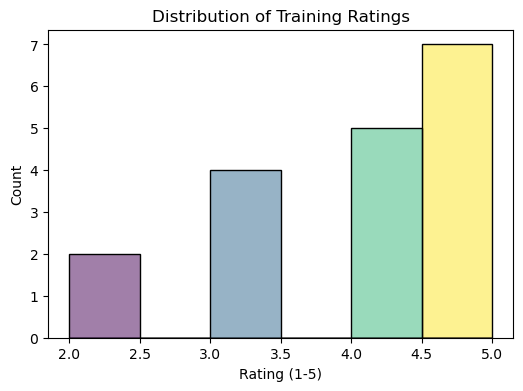

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="Rating", hue="Rating", palette="viridis", legend=False)

plt.title("Distribution of Training Ratings")
plt.xlabel("Rating (1-5)")
plt.ylabel("Count")
plt.show()

##### Here we can see how the training session ratings are distributed. We can use this information to further uderstand how sessions can be improved, focusing on sessions with lower score to see what could be done better.

## Categorise feedback into Positive, Negative or Neutral sentiments

In [10]:
# First we summarise the feedback text

def clean_text(text):
    text = text.lower() 
    text = text.translate(str.maketrans('', '', string.punctuation))  
    words = word_tokenize(text) 
    words = [word for word in words if word not in stopwords.words('english')]  
    return " ".join(words)

df['Cleaned_Feedback'] = df['Feedback_Comment'].apply(clean_text)

print(df[['Feedback_Comment', 'Cleaned_Feedback']].head())

                          Feedback_Comment                    Cleaned_Feedback
0      The session was too fast to follow.                 session fast follow
1       Excellent training, very engaging!         excellent training engaging
2     Would prefer more hands-on practice.       would prefer handson practice
3  The instructor explained concepts well.  instructor explained concepts well
4    Too much information in a short time.         much information short time


In [11]:
# Then we generate a score (between 1-5) based on the feedback being negative neutral or positive.
# scores above 3 are classed positive while scores below 2.5 are classed negative, scores between 2.5-3 are classed as neutral

def get_sentiment(rating):
    if rating > 3:
        return "Positive"
    elif rating < 2.5:
        return "Negative"
    else:
        return "Neutral"
        
df['Sentiment'] = df['Rating'].apply(get_sentiment)

df[['Trainee_ID', 'Feedback_Comment', 'Rating', 'Sentiment']]

,Trainee_ID,Feedback_Comment,Rating,Sentiment
0,1,The session was too fast to follow.,2,Negative
1,2,"Excellent training, very engaging!",5,Positive
2,3,Would prefer more hands-on practice.,3,Neutral
3,4,The instructor explained concepts well.,5,Positive
4,5,Too much information in a short time.,2,Negative
5,6,"Great session, but I need more examples.",3,Neutral
6,7,Enjoyed applying theory to practice,5,Positive
7,8,"Great session, I now understand concepts better",4,Positive
8,9,Very informative and well-structured.,5,Positive
9,10,Enjoyed the training but more visuals needed.,4,Positive


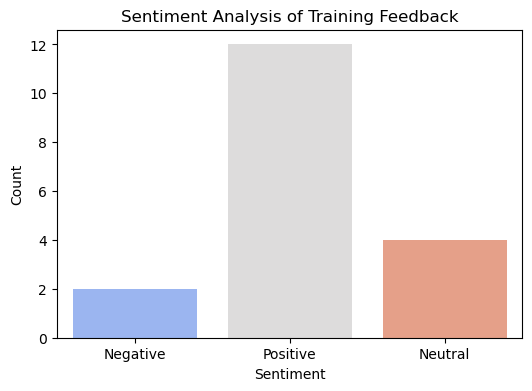

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Sentiment'], hue=df['Sentiment'], palette="coolwarm", legend=False)
plt.title("Sentiment Analysis of Training Feedback")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

#### This diagram shows the distribution of scores. Most trainees found the training sessions to be positive but two people left a negative review. Responses on negative reviews were related to session timing and imformation load. For the next session more time can be allocated to explain concepts more in depth, in turn, reducing the number of negative reviews and imcreasing customer satisfaction. 

In [14]:
vectorizer = TfidfVectorizer(max_features=100)
X_text = vectorizer.fit_transform(df['Cleaned_Feedback']).toarray()


X_text_df = pd.DataFrame(X_text, columns=vectorizer.get_feature_names_out())

df['Feedback_Length'] = df['Cleaned_Feedback'].apply(len)
df['Training_Category'] = pd.cut(df['Training_Duration'], bins=[0, 4, 7, 10], labels=['Short', 'Medium', 'Long'])


encoder = OneHotEncoder(sparse_output=False)
training_category_encoded = encoder.fit_transform(df[['Training_Category']])
training_category_df = pd.DataFrame(training_category_encoded, columns=encoder.get_feature_names_out(['Training_Category']))

X = pd.concat([df[['Training_Duration', 'Rating', 'Sentiment', 'Feedback_Length']], X_text_df, training_category_df], axis=1)
y = df['Rating']

##### We can create a world cloud to visualise the feedback comments easier

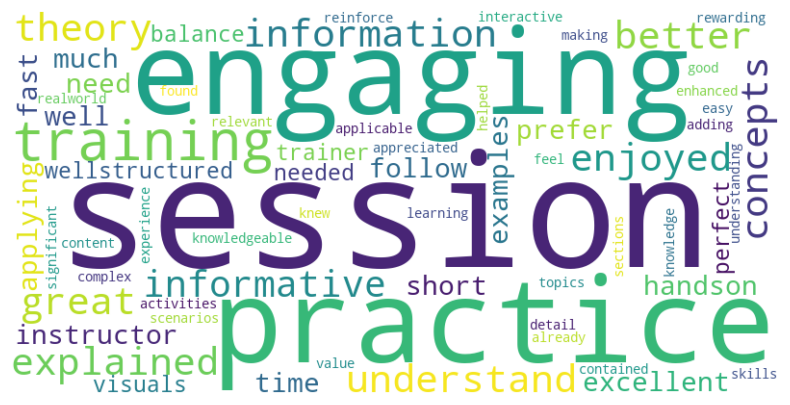

In [16]:
all_words = " ".join(df['Cleaned_Feedback'])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
sentiment_counts = df['Sentiment'].value_counts()
print("Sentiment Breakdown:")
print(sentiment_counts)

if sentiment_counts["Negative"] > 0:
    print("\nKey Improvement Areas Based on Feedback:")
    print("- Consider slowing down session pace.")
    print("- Include more hands-on practice.")
    print("- Provide more real-world case studies.")
    print("- Ensure information is not overwhelming in a short time.")
else:
    print("\nOverall, training was well-received!")

Sentiment Breakdown:
Sentiment
Positive    12
Neutral      4
Negative     2
Name: count, dtype: int64

Key Improvement Areas Based on Feedback:
- Consider slowing down session pace.
- Include more hands-on practice.
- Provide more real-world case studies.
- Ensure information is not overwhelming in a short time.


In [18]:
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

In [19]:
df['Success'] = df['Rating'].apply(lambda x: 1 if x >= 3 else 0)

X = pd.concat([df[['Training_Duration', 'Sentiment', 'Feedback_Length']], 
               X_text_df, training_category_df], axis=1)

y = df['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.75
